In [1]:
import pandas as pd
import walnut

# Example 3

### Deep neural network using multiple linear layers

The goal of this model is to classify iris species based on numerical features.

### Step 1: Prepare data
You will need to download the dataset from https://www.kaggle.com/datasets/uciml/iris and place it into the *data* directory.

In [2]:
data_orig = pd.read_csv('data/iris.csv')
data = data_orig.copy()
data.drop(columns=['Id'], inplace=True)
data.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
data.describe()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  150 non-null    float64
 1   SepalWidthCm   150 non-null    float64
 2   PetalLengthCm  150 non-null    float64
 3   PetalWidthCm   150 non-null    float64
 4   Species        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


The labels are categorical values. To be used in the model, all data needs to be numerical. The function `categorical_to_numeric()` can be used to one-hot-encode all categorical data of a Pandas DataFrame object.

In [5]:
data_enc = walnut.preprocessing.encoding.pd_categorical_to_numeric(data, columns=["Species"])
data_enc.sample(10)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
148,6.2,3.4,5.4,2.3,2
104,6.5,3.0,5.8,2.2,2
17,5.1,3.5,1.4,0.3,0
11,4.8,3.4,1.6,0.2,0
103,6.3,2.9,5.6,1.8,2
32,5.2,4.1,1.5,0.1,0
133,6.3,2.8,5.1,1.5,2
39,5.1,3.4,1.5,0.2,0
88,5.6,3.0,4.1,1.3,1
102,7.1,3.0,5.9,2.1,2


Next the data is split into a training, validation and a testing dataset using the `split_train_test_val_data()` to evaluate the model later on. Before splitting the data is also shuffled, since sometimes raw data is sorted in some way.

In [6]:
tensor = walnut.pd_to_tensor(data_enc)
t_train, t_val, t_test = walnut.preprocessing.split_train_val_test(tensor)
t_train[:5]

tnsor([[  5.0000,   2.3000,   3.3000,   1.0000,   1.0000],
       [  7.2000,   3.6000,   6.1000,   2.5000,   2.0000],
       [  6.0000,   2.2000,   5.0000,   1.5000,   2.0000],
       [  6.9000,   3.1000,   5.4000,   2.1000,   2.0000],
       [  5.4000,   3.4000,   1.7000,   0.2000,   0.0000]], dtype=float32)

Features and labels are now seperated.

In [7]:
x_train, y_train = t_train[:, :-1], t_train[:, -1].astype("int")
x_val, y_val = t_val[:, :-1], t_val[:, -1].astype("int")
x_test, y_test = t_test[:, :-1], t_test[:, -1].astype("int")

In [8]:
y_train[:10]

tnsor([1, 2, 2, 2, 0, 1, 0, 2, 0, 1])

Neural networks tend to run into problems if values are very high. Therefore it is common to normalize the data. This can be done using the `normalize()` function, which applies min-max feature scaling to a tensor.<br><br>
$ X'=a+\frac{(X-X_{min})\cdot(b-a)}{X_{max}-X_{min}} $<br><br>, where<br><br>$ a $ ... lower bound<br>$ b $ ... upper bound

In [9]:
x_train = walnut.preprocessing.normalize(x_train, axis=0)
x_val = walnut.preprocessing.normalize(x_val, axis=0)
x_test = walnut.preprocessing.normalize(x_test, axis=0)
x_train[:5]

tnsor([[ -0.6111,  -0.7500,  -0.2143,  -0.2500],
       [  0.6111,   0.3333,   0.7857,   1.0000],
       [ -0.0556,  -0.8333,   0.3929,   0.1667],
       [  0.4444,  -0.0833,   0.5357,   0.6667],
       [ -0.3889,   0.1667,  -0.7857,  -0.9167]], dtype=float32)

In [10]:
print (f'{x_train.shape=}')
print (f'{y_train.shape=}')

print (f'{x_val.shape=}')
print (f'{y_val.shape=}')

print (f'{x_test.shape=}')
print (f'{y_test.shape=}')

x_train.shape=(120, 4)
y_train.shape=(120,)
x_val.shape=(15, 4)
y_val.shape=(15,)
x_test.shape=(15, 4)
y_test.shape=(15,)


### Step 2: Build the neural network structure
Here the individual layers of the neural network models are defined. If the weights for a layer are not definied, they are initialized randomly. For experimental purposes, they can be manually initialized using various initialization methods, such as `kaiming_normal`.

In [11]:
import walnut.nn as nn
from walnut.nn.layers import *
from walnut.nn.inits import *

n_hidden = 100
gain = get_gain("tanh")

# init = normal
# model = nn.Sequential([
#     Linear(4, n_hidden, weights=init((4, n_hidden))), Tanh(),
#     Linear(n_hidden, n_hidden, weights=init((n_hidden, n_hidden))), Tanh(),
#     Linear(n_hidden, n_hidden, weights=init((n_hidden, n_hidden))), Tanh(),
#     Linear(n_hidden, 3, weights=init((n_hidden, 3)))
# ])

init = kaiming_normal
model = nn.Sequential([
    Linear(4, n_hidden, weights=init((4, n_hidden), gain)), Tanh(),
    Linear(n_hidden, n_hidden, weights=init((n_hidden, n_hidden), gain)), Tanh(),
    Linear(n_hidden, n_hidden, weights=init((n_hidden, n_hidden), gain)), Tanh(),
    Linear(n_hidden, 3, weights=init((n_hidden, 3)))
])

The network is compiled to internally connect it's layers and initialize the model. The SGD optimizer provides an optional momentum term and nesterov momentum.

In [12]:
model.compile(
    optimizer=nn.optimizers.SGD(),
    loss_fn=nn.losses.Crossentropy(),
    metric=nn.metrics.Accuracy()
)

In [13]:
model

Sequential

Linear (in_channels=4, out_channels=100, use_bias=True)
Tanh
Linear (in_channels=100, out_channels=100, use_bias=True)
Tanh
Linear (in_channels=100, out_channels=100, use_bias=True)
Tanh
Linear (in_channels=100, out_channels=3, use_bias=True)

In [14]:
from walnut.nn.verbose import summary
summary(model, (4,))

---------------------------------------------------------
Layer (type)         Output Shape            # Parameters
Linear               (-1, 100)                        500
Tanh                 (-1, 100)                          0
Linear               (-1, 100)                      10100
Tanh                 (-1, 100)                          0
Linear               (-1, 100)                      10100
Tanh                 (-1, 100)                          0
Linear               (-1, 3)                          303

Total parameters: 21003


### Step 3: Train the model

In [15]:
train_loss_hist, val_loss_hist = model.train(x_train, y_train, epochs=100, val_data=(x_val, y_val), reset_grads=False)

epoch     0/  100 | step     4.01 ms | loss 1.896721 | val_loss 1.547997
epoch    10/  100 | step     4.00 ms | loss 0.562009 | val_loss 0.495564
epoch    20/  100 | step     3.00 ms | loss 0.422230 | val_loss 0.393267
epoch    30/  100 | step     2.97 ms | loss 0.365356 | val_loss 0.360854
epoch    40/  100 | step     3.00 ms | loss 0.332261 | val_loss 0.346170
epoch    50/  100 | step     3.00 ms | loss 0.309650 | val_loss 0.337928
epoch    60/  100 | step     3.00 ms | loss 0.292693 | val_loss 0.332422
epoch    70/  100 | step     3.00 ms | loss 0.279184 | val_loss 0.328162
epoch    80/  100 | step     2.00 ms | loss 0.267958 | val_loss 0.324470
epoch    90/  100 | step     3.00 ms | loss 0.258339 | val_loss 0.321013
epoch   100/  100 | step     3.00 ms | loss 0.249901 | val_loss 0.317620


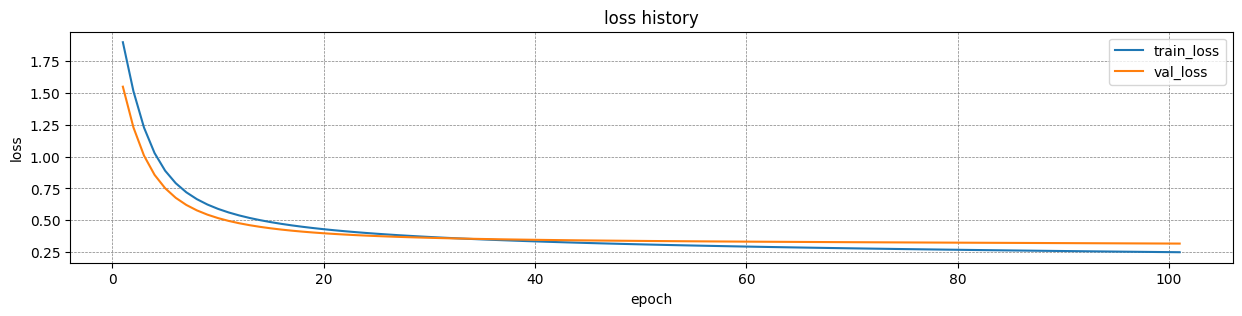

In [16]:
traces = {
    "train_loss" : train_loss_hist,
    "val_loss" : val_loss_hist
}

nn.analysis.plot_curve(traces=traces, figsize=(15, 3), title="loss history", x_label="epoch", y_label="loss")

### Step 4: Evaluate the model
Using the defined metric, the model's performance can be evaluated using testing/validation data.

In [17]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f'loss {loss:.4f}')
print(f'accuracy {100*accuracy:.2f}')

loss 0.4787
accuracy 80.00


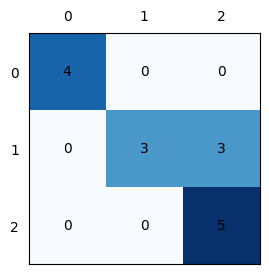

In [18]:
predictions = model(x_test)
nn.analysis.plot_confusion_matrix(predictions, y_test, (3, 3), cmap='Blues')

### Step 5: Analyze the model
Usind different plots, the models performance and training behaviour can be analyzed (eg. checking for overfitting)

If the `normal` weight initialization method is used, the **tanh** activations get saturated very fast and the gradients "die out". If other initializers, such as `kaiming_normal` are used, this couteracts this behaviour. Furthermore the initial loss is lower and the model is therefore not wasting time correcting unnecessary high weight values in the beginning (Analysis inspired by Andrej Karpathy - highly recommend checking out his videos on YouTube)

2 Tanh     | mean 0.0364 | std 0.5918
4 Tanh     | mean 0.0068 | std 0.6177
6 Tanh     | mean -0.0283 | std 0.6343


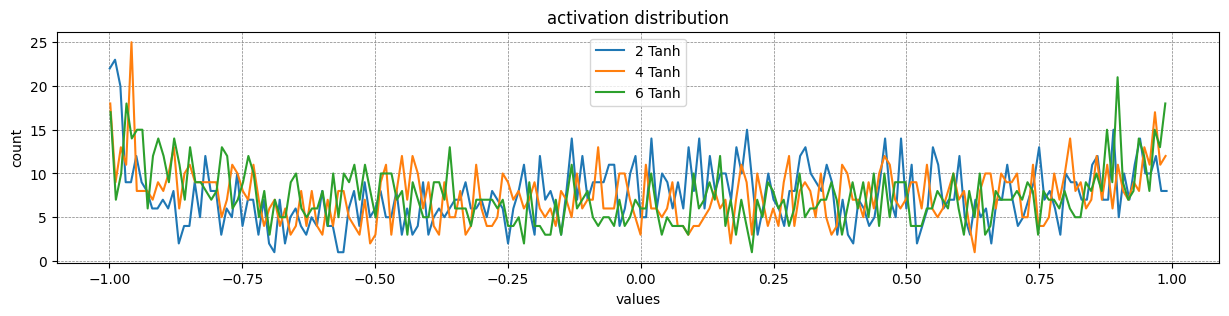

In [19]:
activations = {f"{i + 1} {l.__class__.__name__}" : l.y.data.copy() for i, l in enumerate(model.layers) if l.__class__.__name__ == "Tanh"}
nn.analysis.plot_distrbution(activations, figsize=(15, 3), title="activation distribution", bins=200)

As mentioned, the gradient of saturated neurons get very close to zero. If that happens for all batches, then the neuron is not learning and it is considererd dead (white pixels in the plot). By using the Kaiming He initialization method this can be reduced.

2 Tanh


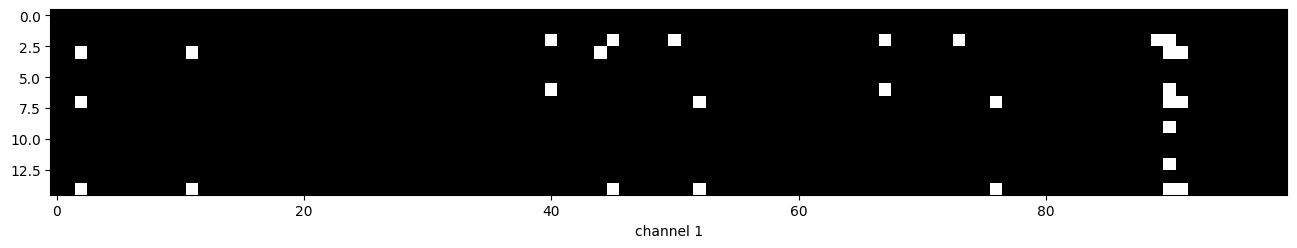

4 Tanh


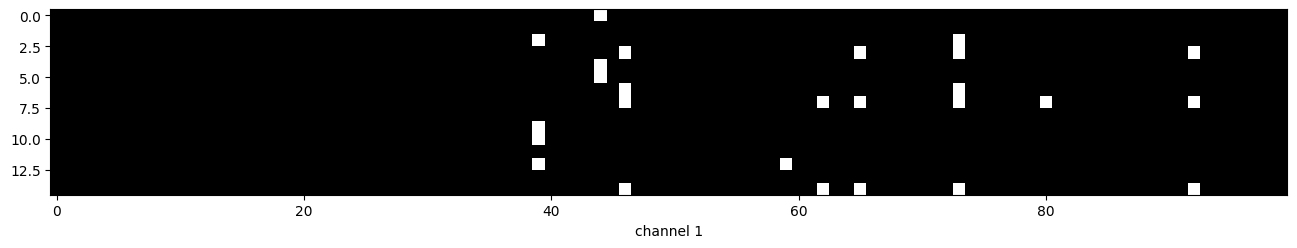

6 Tanh


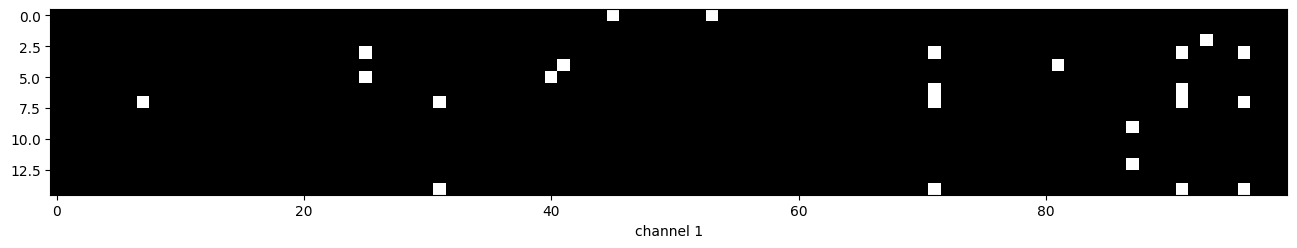

In [20]:
saturations = {f"{i + 1} {l.__class__.__name__}" : (l.y.abs() > 0.99).data for i, l in enumerate(model.layers) if l.__class__.__name__ == "Tanh"}
nn.analysis.plot_images(saturations, (150, 30), "gray", plot_axis=True)

1 Linear   | mean 0.0000 | std 0.0015
3 Linear   | mean -0.0000 | std 0.0013
5 Linear   | mean -0.0000 | std 0.0012
7 Linear   | mean 0.0000 | std 0.0104


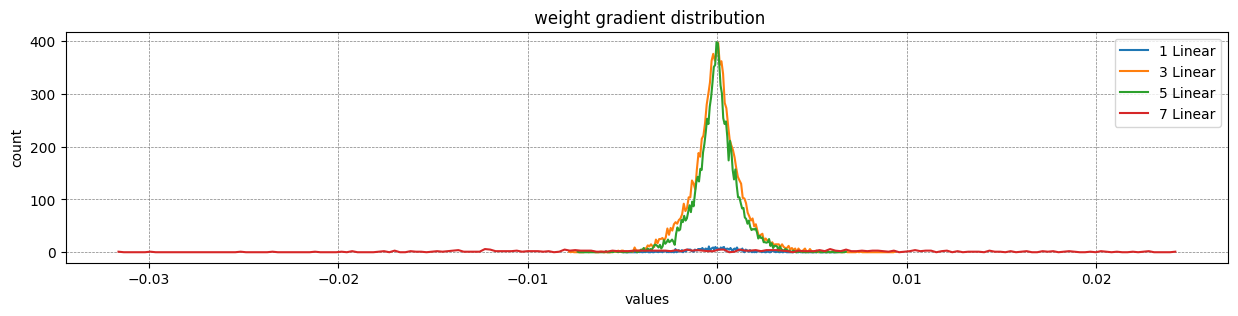

In [21]:
weight_gradients = {f"{i + 1} {l.__class__.__name__}" : l.w.grad.copy() for i, l in enumerate(model.layers) if l.__class__.__name__ == "Linear"}
nn.analysis.plot_distrbution(weight_gradients, figsize=(15, 3), title=" weight gradient distribution", bins=200)

2 Tanh     | mean -0.0000 | std 0.0005
4 Tanh     | mean -0.0000 | std 0.0004
6 Tanh     | mean -0.0000 | std 0.0003


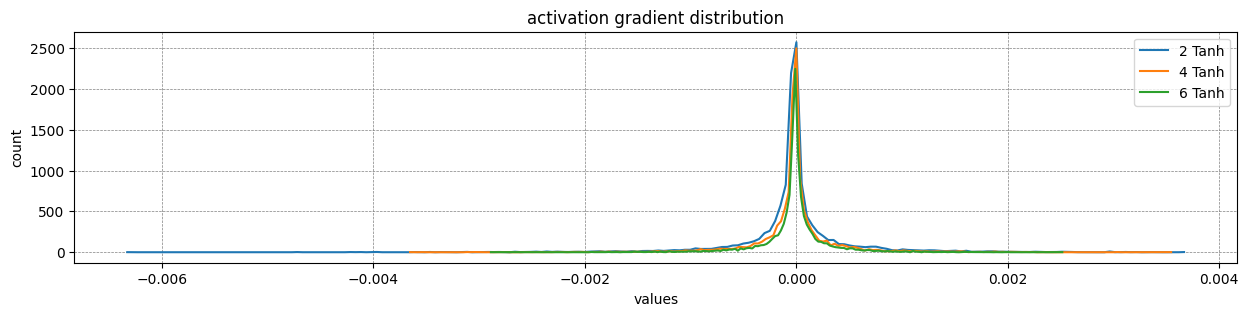

In [22]:
act_gradients = {f"{i + 1} {l.__class__.__name__}" : l.y.grad.copy() for i, l in enumerate(model.layers) if l.__class__.__name__ == "Tanh"}
nn.analysis.plot_distrbution(act_gradients, figsize=(15, 3), title="activation gradient distribution", bins=200)